## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [Resources](#resources)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Import libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Read in the `ab_data.csv` data.  

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
#return number of unique rows and also returns number of unique users unique users
df.nunique()    

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

**The above result returns unique rows of user-ids, which shows 290584 unique values in the dataset out of 294478 rows.This mismatch has to be resolved.**

d. The proportion of users converted.

In [6]:
df.converted.mean()*100

11.96591935560551

e. The number of times the `new_page` and `treatment` don't line up.

Accordingly, there are two unique values which are treatment and control for groups and old_page and new_page for landing_page. Hence, we need to find the number of rows where treatment was aligned with old_page and control was aligned with new page as follows:

In [7]:
treatment_old = df.query("group == 'treatment' and landing_page == 'old_page'").shape[0]
control_new = df.query("group == 'control' and landing_page == 'new_page'").shape[0]
dontlineup = treatment_old + control_new
dontlineup

3893

f. None of the rows have missing values.

In [8]:
#checks the rows having missing values
df.info() # it seems like there are no null(NaN) values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**The above result checks if there are any null values. And found that there are no null values**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Using the answer from the previous exercise, we will create a new dataset that meets the specifications then store our new dataframe in **df2**.

In [9]:
df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)
df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)
df.info()
df.to_csv('ab_data2.csv', index=False)
df2 = pd.read_csv('ab_data2.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [10]:
# Double Checking- all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** to answer below questions.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated(keep=False)].user_id

1876    773192
2862    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates('user_id', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290584
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the below cells to answer the questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query("group == 'control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2.query("landing_page == 'new_page'").shape[0] / df2.landing_page.shape[0]

0.5000619442226688

e. Considering our results from a. through d. above, is there a sufficient evidence to say that the new treatment page leads to more conversions?

**From the above data, we can see that the number of individuals who converted from either group is almost identical which was equivalent to 12%. Hence, there is no concrete evidence suggesting that those who explore either page will neccessarily lead to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be? hypothesis can be stated in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$$H_0: p_{old} - p_{new} \ge 0$$ $$H_1: p_{old} - p_{new} \lt 0$$**

`2.` We assume that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we also assume that they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Sample size for each page equal to the ones in **ab_data.csv** is used.  <br><br>

The sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null is performed.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [24]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [27]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [53]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = [1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [54]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [55]:
p_diff = new_page_converted.mean() - old_page_converted.mean()

p_diff

0.001429283181776625

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one we calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [56]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [1-p_new, p_new]).mean()
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [1-p_old, p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what was expected? 

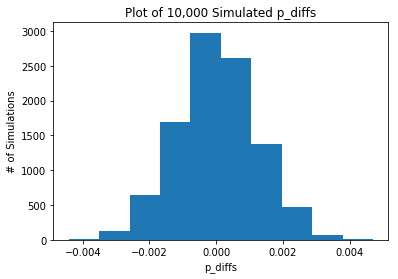

In [57]:
plt.hist(p_diffs);
plt.ylabel('# of Simulations')
plt.xlabel('p_diffs')
plt.title('Plot of 10,000 Simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [58]:
p_diffs = np.array(p_diffs)
act_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
(p_diffs > act_diffs).mean()

0.9081

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Actual difference represents the difference between converted rates of new page and old page, based on our data.**

**p-diffs represents the simuated difference between converted rates of new page and old page, based on 10000 simulated samples..**

**The percentage of 90.8 is called scientifically p-value. This is far greater than the typical $\alpha$ level of 0.05, which states that old pages are the same or slightly better than the new pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. The number of conversions for each page, as well as the number of individuals who received each page are caluclated below. Let `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [38]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]
print(convert_old)
print(n_old)
print(convert_new)
print(n_new)

17489
145274
17264
145310


m. Using `stats.proportions_ztest` to compute our test statistic and p-value.  

In [39]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [40]:
#Next we import the norm function to compute the ext we check our critical value at 95% confidence interval.
from scipy.stats import norm
print(norm.ppf(1-(0.05)))

1.6448536269514722


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**In part m. z_score is 1.31. Since this value is less than the critical value at 95% confidence interval (1.64), there is no statistical evidence to reject the null hypothesis. Furthermore, p-value obtained is similar to the result obtained from the previous findings in j. and k. Which also fails to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should we perform in this case?

**Rows with either conversions or no conversions predicts a probability between 0 and 1. So, `Logistic Regression` should be performed.**

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Have to add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [41]:
#Create intercept column
df2['intercept']=1

#Create dummies
ab_page = ['treatment', 'control']
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Using **statsmodels** to import regression model.  Instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [42]:
logit = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

d. Providing the summary of our model below, and using it as necessary to answer the following questions.

In [43]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        06:40:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with our regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page was 0.19 which was significantly lower than the one in Part II which was approximately 0.9. The reason for such a significant difference is because the null and alternative hypothesis differed in each exercise.**

 $$H_0: p_{old} - p_{new} \ge 0$$
 $$H_1: p_{old} - p_{new}  \lt 0$$

 $$H_0: p_{old} = p_{new}$$
 $$H_1: p_{old} \ne p_{new}$$

**Because the later case relies solely on two possible outcomes.**

f. Now, we are considering other things that might influence whether or not an individual converts.  Shall discuss why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into our regression model?

**Considering other factors/explanatory variables like which country or age or gender or time stamp of user might influence whether or not an individual converts or not to new page. This makes our hypothesis results more reliable.**

**This may also produce inaccurate results due to correlated errors.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together with our datasets on the approporiate rows.  

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [44]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [45]:
#number of unique rows under country column:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [46]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [47]:
#Computing the statistical output:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 26 Jul 2019   Pseudo R-squ.:               1.521e-05
Time:                        06:41:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**According to our statistical output the p-value for both countries yields a value larger than 0.05; hence, there is no statistical evidence on country's significant impact on conversion.**

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Shall create the necessary additional columns, and fit the new model.  

Shall provide the summary results, and our conclusions based on the results.

In [48]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 26 Jul 2019   Pseudo R-squ.:               2.323e-05
Time:                        06:41:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

**According to results above, there is no significant impact of the countries and new page on conversion rates since p-values were all exceeding 0.05.**

**Also it was found that the old page was better than the new page, therefore it fails to reject the null hypothesis.**

**The company should not implement the new page as there is no proper evidence that it is better than the old page.**


<a id='resources'></a>
## Resources

[Helpful link on using the built in](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 

[Joining tables tutorial](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html). 